### Fraud Detection models
* See Notebook **fraud_detection_imbalance_classes** in this repo for **Weighted Logistic Regression**.

In this notebook we train and compare two models to detect fraud in data:
1. **Logistic Regression**  
2. **AdaBoost Classifier** 

The accuracy of both the **Logistic Regression** and **AdaBoost Classifier** models using the test data are greater than **85%**!! This suggests that the model is **really good** but can further be improved by tuning some hyper-parameters.

**The CAP curve analysis shows that that if 50% of the data is analysed without the model only 50% of the fraudulent cases would be discovered. But using the model, we would be able to identify more than 90% of the fraudulent cases in the same amount of data!!** 

#### Using the model: 
* the amount of **backlog** (incoming and unfinished work) would be **reduced significantly**, 
* the **amount of staff** needed to do the job would be **reduced drastically**, 
* the **processing time** would be **shortened significantly** and 
* **more cases of fraudulent transactions** would be tracked down in a given amount of data processed - **`more than 40% increase in effeciency!`**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from statsmodels.formula.api import ols
from sklearn import metrics, linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, f_classif
from sklearn.metrics import roc_curve, auc, confusion_matrix
from classification_evaluation import cap_curve

%matplotlib inline

#### Read the data `FraudDetection.xlsx` into a DataFrame 

In [2]:
df = pd.read_excel('./data/FraudDetection.xlsx', na_values = 'NA')
print(df.shape)
df.head()

(16281, 15)


,Transaction_ID,Card Tenure_months,WebsiteRegion,Trans_value,Seller_Category,Items_transaction,Shipping_Address,Purchase_Category,Othercard_owner,Seller_way,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Countryissuedcard,Fraud_Detected
0,1,25,US,256.41,Store + online,10,US,online services,Dependent,Yes,0,0,40,United-States,No
1,2,38,US,409.54,Online only,8,International,Accessories,Husband,Yes,0,0,50,United-States,No
2,3,28,EU,293.09,Online only,5,International,Electornics,Husband,Yes,0,0,40,United-States,Yes
3,4,44,US,444.07,Online only,7,International,online services,Husband,Yes,7688,0,40,United-States,Yes
4,5,18,EU,183.11,Online only,7,US,Food,Dependent,No,0,0,30,United-States,No


#### Any missing values?

In [3]:
z = df.isnull().sum()
print(z[z > 0])

Othercard_owner    6482
dtype: int64


In [4]:
df.drop('Othercard_owner', axis = 1, inplace = True)

In [5]:
z = df.isnull().sum()
print(z[z > 0])

Series([], dtype: int64)


#### Change column names `Transaction_ID` to `ID` and `Fraud_Detected` to `target`.

In [6]:
df_new = df.copy()
df_new.rename(columns = {'Transaction_ID': 'ID', 'Fraud_Detected': 'target'}, inplace = True)
df_new.head()

,ID,Card Tenure_months,WebsiteRegion,Trans_value,Seller_Category,Items_transaction,Shipping_Address,Purchase_Category,Seller_way,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Countryissuedcard,target
0,1,25,US,256.41,Store + online,10,US,online services,Yes,0,0,40,United-States,No
1,2,38,US,409.54,Online only,8,International,Accessories,Yes,0,0,50,United-States,No
2,3,28,EU,293.09,Online only,5,International,Electornics,Yes,0,0,40,United-States,Yes
3,4,44,US,444.07,Online only,7,International,online services,Yes,7688,0,40,United-States,Yes
4,5,18,EU,183.11,Online only,7,US,Food,No,0,0,30,United-States,No


##### Convert the 'target' into binary `Yes/No = 1/0`

In [7]:
df_new['Y'] = (df_new.target == 'Yes') + 0                 
df_new.head()

,ID,Card Tenure_months,WebsiteRegion,Trans_value,Seller_Category,Items_transaction,Shipping_Address,Purchase_Category,Seller_way,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Countryissuedcard,target,Y
0,1,25,US,256.41,Store + online,10,US,online services,Yes,0,0,40,United-States,No,0
1,2,38,US,409.54,Online only,8,International,Accessories,Yes,0,0,50,United-States,No,0
2,3,28,EU,293.09,Online only,5,International,Electornics,Yes,0,0,40,United-States,Yes,1
3,4,44,US,444.07,Online only,7,International,online services,Yes,7688,0,40,United-States,Yes,1
4,5,18,EU,183.11,Online only,7,US,Food,No,0,0,30,United-States,No,0


#### Data types of variables

In [8]:
print(df_new.dtypes)

ID                        int64
Card Tenure_months        int64
WebsiteRegion            object
Trans_value             float64
Seller_Category          object
Items_transaction         int64
Shipping_Address         object
Purchase_Category        object
Seller_way               object
LastTransaction           int64
Lastflagedvalue           int64
LastMonthsTrans_Freq      int64
Countryissuedcard        object
target                   object
Y                         int32
dtype: object


#### `char` variables in data 

In [9]:
df_obj = df_new.select_dtypes(include = ['object'])
df_obj.head()

,WebsiteRegion,Seller_Category,Shipping_Address,Purchase_Category,Seller_way,Countryissuedcard,target
0,US,Store + online,US,online services,Yes,United-States,No
1,US,Online only,International,Accessories,Yes,United-States,No
2,EU,Online only,International,Electornics,Yes,United-States,Yes
3,US,Online only,International,online services,Yes,United-States,Yes
4,EU,Online only,US,Food,No,United-States,No


In [10]:
char_variables = list(df_obj)
print(char_variables)

['WebsiteRegion', 'Seller_Category', 'Shipping_Address', 'Purchase_Category', 'Seller_way', 'Countryissuedcard', 'target']


### Selecting good predictors of the target using Chi-squared statistics
* Check relationship between **'WebsiteRegion'** and **target** by first creating a **cross tab** showing frequency in each cell.

In [11]:
table = pd.crosstab(df_obj['WebsiteRegion'], df_obj['target'], margins = False)
table

target,No,Yes
WebsiteRegion,,
EU,1625,384
Eastern Europe,793,369
US,9049,2740
Unclassified,968,353


Calculate **Chi-squared statistics, p value, degree of freedom, expected** and confirm if it looks like significant.

In [12]:
chi_square, p_value, dof, expected = stats.chi2_contingency(table)

print(f'chi-square = {round(chi_square, 3)}')
print(f'pvalue = {round(p_value, 3)}')
print(f'deg. of freedom(dof) = {dof}\n')
print(f'expected:\n{expected}')

chi-square = 73.216
pvalue = 0.0
deg. of freedom(dof) = 3

expected:
[[1534.42141146  474.57858854]
 [ 887.50506726  274.49493274]
 [9004.12843191 2784.87156809]
 [1008.94508937  312.05491063]]


A large **chi-square = 73.216** and a very small **pvalue = 0.0 << 0.05** mean that the variable **'WebsiteRegion'**, is **correlated** with **'target'**. This means **'WebsiteRegion'** is a good predictor and can be used in the final model to predict the **'target'**.  

#### Chi-squared statistics for all the character variables

In [13]:
chi_sqs = []
pvals = []
for var in char_variables[:-1]:
    table = pd.crosstab(df_obj[var], df_obj['target'], margins = False)
    chi_sq, p_value, dof, expected = stats.chi2_contingency(table)
    chi_sqs.append(round(chi_sq, 3))
    pvals.append(round(p_value, 3))
    
print(f'chi-squares:\n{chi_sqs}\n')
print(f'pvalues:\n{pvals}')

chi-squares:
[73.216, 343.931, 3272.593, 1798.965, 729.93, 13.211]

pvalues:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


All the **chi-square statistics** are relatively large enough and the all **pvalues are less than 0.05**. This suggests that all the variables are **correlated with the target**. These variables can therefore be included in the final model to predict the target.

### Levels for each categorical variable 
* The number of dummy variables will depend on the number of levels of each categorical variable.

In [14]:
for var in char_variables[:-1]:
            varnames = list(df_obj[var].unique())
            print(f'Levels of {var} is {varnames}')
            print(f'Number of levels for {var} is {len(varnames)}\n') 

Levels of WebsiteRegion is ['US', 'EU', 'Unclassified', 'Eastern Europe']
Number of levels for WebsiteRegion is 4

Levels of Seller_Category is ['Store + online', 'Online only']
Number of levels for Seller_Category is 2

Levels of Shipping_Address is ['US', 'International', 'Canada']
Number of levels for Shipping_Address is 3

Levels of Purchase_Category is ['online services', 'Accessories', 'Electornics', 'Food', 'Books', 'Paying bills', 'Tickets - flights']
Number of levels for Purchase_Category is 7

Levels of Seller_way is ['Yes', 'No']
Number of levels for Seller_way is 2

Levels of Countryissuedcard is ['United-States', 'Other']
Number of levels for Countryissuedcard is 2



### Value Counts for each level of each CHAR feature in the data frame

In [15]:
for var in char_variables[:-1]:
    print(f'Number of observations for each level of "{var}": \n{df_obj[var].value_counts()}\n')

Number of observations for each level of "WebsiteRegion": 
WebsiteRegion
US                11789
EU                 2009
Unclassified       1321
Eastern Europe     1162
Name: count, dtype: int64

Number of observations for each level of "Seller_Category": 
Seller_Category
Online only       13479
Store + online     2802
Name: count, dtype: int64

Number of observations for each level of "Shipping_Address": 
Shipping_Address
US               7834
International    7417
Canada           1030
Name: count, dtype: int64

Number of observations for each level of "Purchase_Category": 
Purchase_Category
Accessories          3211
Food                 2813
online services      2741
Paying bills         2372
Electornics          2366
Books                2020
Tickets - flights     758
Name: count, dtype: int64

Number of observations for each level of "Seller_way": 
Seller_way
Yes    10860
No      5421
Name: count, dtype: int64

Number of observations for each level of "Countryissuedcard": 
Country

### Feature engineering 
Create dummy variables for each categorical variable in data frame.

In [16]:
import warnings
warnings.filterwarnings('ignore')

The variable **'WebsiteRegion'** and **'Shipping_Address'** for example have similar categories like **US**. In order to make sure that **no two categorical variables** will have the **same header for different dummies** we will add prefixes as below. 

In [17]:
df_obj['WebsiteRegion'] = df_obj.WebsiteRegion + "_WE1"         
df_obj['Seller_Category'] = df_obj.Seller_Category + "_SC2"     
df_obj['Shipping_Address'] = df_obj.Shipping_Address + "_SA3"
df_obj['Purchase_Category'] = df_obj.Purchase_Category + "_PC4"
df_obj['Seller_way'] = df_obj.Seller_way +"_SW5"
df_obj['Countryissuedcard'] = df_obj.Countryissuedcard + "_CO6"

df_obj.head()

,WebsiteRegion,Seller_Category,Shipping_Address,Purchase_Category,Seller_way,Countryissuedcard,target
0,US_WE1,Store + online_SC2,US_SA3,online services_PC4,Yes_SW5,United-States_CO6,No
1,US_WE1,Online only_SC2,International_SA3,Accessories_PC4,Yes_SW5,United-States_CO6,No
2,EU_WE1,Online only_SC2,International_SA3,Electornics_PC4,Yes_SW5,United-States_CO6,Yes
3,US_WE1,Online only_SC2,International_SA3,online services_PC4,Yes_SW5,United-States_CO6,Yes
4,EU_WE1,Online only_SC2,US_SA3,Food_PC4,No_SW5,United-States_CO6,No


### Numeric Features in DataFrame

In [18]:
df_num = df_new.select_dtypes(include = ['number'])
df_num.head()

,ID,Card Tenure_months,Trans_value,Items_transaction,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Y
0,1,25,256.41,10,0,0,40,0
1,2,38,409.54,8,0,0,50,0
2,3,28,293.09,5,0,0,40,1
3,4,44,444.07,7,7688,0,40,1
4,5,18,183.11,7,0,0,30,0


In [19]:
for var in char_variables[:-1]:
    print(f'Original variable name: {var}')

Original variable name: WebsiteRegion
Original variable name: Seller_Category
Original variable name: Shipping_Address
Original variable name: Purchase_Category
Original variable name: Seller_way
Original variable name: Countryissuedcard


### Create Dummies for categorical features

In [20]:
df_obj_dummies = pd.DataFrame([])
for var in char_variables[:-1]:
        df_temp = pd.get_dummies(df_obj[var])
        df_obj_dummies = pd.concat([df_obj_dummies, df_temp], axis = 1)

print(f'dummy names:\n{list(df_obj_dummies)}\n')
print(f'Number of dummies: {len(list(df_obj_dummies))}')
print(f'shape: {df_obj_dummies.shape}')

dummy names:
['EU_WE1', 'Eastern Europe_WE1', 'US_WE1', 'Unclassified_WE1', 'Online only_SC2', 'Store + online_SC2', 'Canada_SA3', 'International_SA3', 'US_SA3', 'Accessories_PC4', 'Books_PC4', 'Electornics_PC4', 'Food_PC4', 'Paying bills_PC4', 'Tickets - flights_PC4', 'online services_PC4', 'No_SW5', 'Yes_SW5', 'Other_CO6', 'United-States_CO6']

Number of dummies: 20
shape: (16281, 20)


In [21]:
df_obj_dummies.head()

,EU_WE1,Eastern Europe_WE1,US_WE1,Unclassified_WE1,Online only_SC2,Store + online_SC2,Canada_SA3,International_SA3,US_SA3,Accessories_PC4,Books_PC4,Electornics_PC4,Food_PC4,Paying bills_PC4,Tickets - flights_PC4,online services_PC4,No_SW5,Yes_SW5,Other_CO6,United-States_CO6
0,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,True
1,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,True
2,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True
3,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,True
4,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True


### Drop any duplicates (by ID) in data (only keep last one)

In [22]:
print(df_num.shape)
df_num = df_num.drop_duplicates('ID', keep = 'last')
print(df_num.shape)

(16281, 8)
(16281, 8)


### Standardization for numerical features
Scipy's **`zscore`** would transform the features to have standard normal distribution having **`mean = 0`** and **`standard deviation = 1`**.

In [23]:
Y = df_num['Y']

df_num_scaled = df_num.iloc[:, 1:-1].apply(zscore)
df_num_scaled.head()

,Card Tenure_months,Trans_value,Items_transaction,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq
0,-0.994129,-1.053243,1.196864,-0.142662,-0.218062,-0.031432
1,-0.055417,0.049638,0.417886,-0.142662,-0.218062,0.769918
2,-0.777503,-0.789064,-0.750582,-0.142662,-0.218062,-0.031432
3,0.377835,0.298332,0.028397,0.871091,-0.218062,-0.031432
4,-1.499590,-1.581168,0.028397,-0.142662,-0.218062,-0.832781


### Create a DataFrame with numeric features (numeric plus dummies)

In [24]:
X_train_df = pd.concat([df_num_scaled , df_obj_dummies], axis = 1)   
print(X_train_df.shape)
X_train_df.head()

(16281, 26)


,Card Tenure_months,Trans_value,Items_transaction,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,EU_WE1,Eastern Europe_WE1,US_WE1,Unclassified_WE1,...,Books_PC4,Electornics_PC4,Food_PC4,Paying bills_PC4,Tickets - flights_PC4,online services_PC4,No_SW5,Yes_SW5,Other_CO6,United-States_CO6
0,-0.994129,-1.053243,1.196864,-0.142662,-0.218062,-0.031432,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
1,-0.055417,0.049638,0.417886,-0.142662,-0.218062,0.769918,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
2,-0.777503,-0.789064,-0.750582,-0.142662,-0.218062,-0.031432,True,False,False,False,...,False,True,False,False,False,False,False,True,False,True
3,0.377835,0.298332,0.028397,0.871091,-0.218062,-0.031432,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
4,-1.499590,-1.581168,0.028397,-0.142662,-0.218062,-0.832781,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True


In [25]:
print(len(Y))             

16281


### Determined the AUC of each variable with the target.
This would give an clue of which feature is a good predictor of the target variable.

In [26]:
for var in list(X_train_df):
    fpr, tpr, thresholds = roc_curve(np.array(Y), np.array(X_train_df[var]))          
    print(f'The single AUC of {var} is {auc(fpr, tpr)}\n')

The single AUC of Card Tenure_months is 0.6783597431553071

The single AUC of Trans_value is 0.677623737036333

The single AUC of Items_transaction is 0.28531270563247135

The single AUC of LastTransaction is 0.5891427936972726

The single AUC of Lastflagedvalue is 0.5330136156793276

The single AUC of LastMonthsTrans_Freq is 0.6714938167289458

The single AUC of EU_WE1 is 0.4845822300925813

The single AUC of Eastern Europe_WE1 is 0.5160861126845557

The single AUC of US_WE1 is 0.4923622180110364

The single AUC of Unclassified_WE1 is 0.5069694392118266

The single AUC of Online only_SC2 is 0.5646654334207144

The single AUC of Store + online_SC2 is 0.4353345665792856

The single AUC of Canada_SA3 is 0.4715209259757604

The single AUC of International_SA3 is 0.7627954913130179

The single AUC of US_SA3 is 0.2656835827112216

The single AUC of Accessories_PC4 is 0.4668894789567216

The single AUC of Books_PC4 is 0.578779073961511

The single AUC of Electornics_PC4 is 0.5788243013435856

### Feature selection
Based on the **single AUCs** let's select **18** features (**single AUC > 0.5**)

In [27]:
selector = SelectKBest(f_classif, k = 18)               

X_train_new = selector.fit_transform(X_train_df, Y)    
print(X_train_new.shape)                               

(16281, 18)


#### Check which feature is selected

In [28]:
print(selector.get_support(indices = False))     

[ True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True  True  True False False  True  True  True
 False False]


In [29]:
num_rows = X_train_df.shape[0]
chosen_indices = selector.get_support(indices = True)     # selected features      
selected_df = X_train_df.iloc[0:num_rows, chosen_indices]
print(selected_df.shape)

(16281, 18)


In [30]:
selected_df.head()

,Card Tenure_months,Trans_value,Items_transaction,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Online only_SC2,Store + online_SC2,Canada_SA3,International_SA3,US_SA3,Accessories_PC4,Books_PC4,Electornics_PC4,Food_PC4,online services_PC4,No_SW5,Yes_SW5
0,-0.994129,-1.053243,1.196864,-0.142662,-0.218062,-0.031432,False,True,False,False,True,False,False,False,False,True,False,True
1,-0.055417,0.049638,0.417886,-0.142662,-0.218062,0.769918,True,False,False,True,False,True,False,False,False,False,False,True
2,-0.777503,-0.789064,-0.750582,-0.142662,-0.218062,-0.031432,True,False,False,True,False,False,False,True,False,False,False,True
3,0.377835,0.298332,0.028397,0.871091,-0.218062,-0.031432,True,False,False,True,False,False,False,False,False,True,False,True
4,-1.499590,-1.581168,0.028397,-0.142662,-0.218062,-0.832781,True,False,False,False,True,False,False,False,True,False,True,False


In [31]:
print(selected_df.dtypes)

Card Tenure_months      float64
Trans_value             float64
Items_transaction       float64
LastTransaction         float64
Lastflagedvalue         float64
LastMonthsTrans_Freq    float64
Online only_SC2            bool
Store + online_SC2         bool
Canada_SA3                 bool
International_SA3          bool
US_SA3                     bool
Accessories_PC4            bool
Books_PC4                  bool
Electornics_PC4            bool
Food_PC4                   bool
online services_PC4        bool
No_SW5                     bool
Yes_SW5                    bool
dtype: object


In [32]:
z = selected_df.isnull().sum()
print(z[z > 0])

Series([], dtype: int64)


In [33]:
num_type = ['bool', 'float64']    
df_num_final = selected_df.select_dtypes(include = num_type)

predictor_vars = list(df_num_final)
print(predictor_vars)

['Card Tenure_months', 'Trans_value', 'Items_transaction', 'LastTransaction', 'Lastflagedvalue', 'LastMonthsTrans_Freq', 'Online only_SC2', 'Store + online_SC2', 'Canada_SA3', 'International_SA3', 'US_SA3', 'Accessories_PC4', 'Books_PC4', 'Electornics_PC4', 'Food_PC4', 'online services_PC4', 'No_SW5', 'Yes_SW5']


In [34]:
for var in predictor_vars:
    fpr, tpr, thresholds = roc_curve(np.array(Y), np.array(df_num_final[var]))
    if auc(fpr, tpr) + 0 > 0.5:
        z = auc(fpr, tpr) + 0
    else:       
        z = 1 - auc(fpr, tpr) + 0
    print(f'The AUC of {var} is {z}')

The AUC of Card Tenure_months is 0.6783597431553071
The AUC of Trans_value is 0.677623737036333
The AUC of Items_transaction is 0.7146872943675286
The AUC of LastTransaction is 0.5891427936972726
The AUC of Lastflagedvalue is 0.5330136156793276
The AUC of LastMonthsTrans_Freq is 0.6714938167289458
The AUC of Online only_SC2 is 0.5646654334207144
The AUC of Store + online_SC2 is 0.5646654334207144
The AUC of Canada_SA3 is 0.5284790740242395
The AUC of International_SA3 is 0.7627954913130179
The AUC of US_SA3 is 0.7343164172887784
The AUC of Accessories_PC4 is 0.5331105210432784
The AUC of Books_PC4 is 0.578779073961511
The AUC of Electornics_PC4 is 0.5788243013435856
The AUC of Food_PC4 is 0.5554055189951868
The AUC of online services_PC4 is 0.5777021792572548
The AUC of No_SW5 is 0.6175470323999932
The AUC of Yes_SW5 is 0.6175470323999932


The **single AUCs** are all greater than **`0.5`**! This is indication that there feature are good predictors.

### Training the models
I will train a `LogisticRegression` and an `AdaBoostClassifier` model and compare their performances.
I will use **Cummulative Accuracy Profile - (CAP)** to evaluate the models robustness.

In [35]:
X = df_num_final
y = Y
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.3, random_state = 0)

### LogisticRegression Model
#### Cross Validation Score

In [36]:
log_reg = linear_model.LogisticRegression(C = 0.01, penalty = 'l2')
log_reg.fit(X_train, y_train)

scores = cross_val_score(log_reg, X, y)
print(f'logistic regression score: {scores.mean()}\n') 

logistic regression score: 0.8427002811559152



### The Predictions (LogisticRegression Model)

In [37]:
y_pred = log_reg.predict_proba(X_test,)[:, 1]                    
print(f'First 10 probabilities:\n{y_pred[0:10]}')

First 10 probabilities:
[0.37844127 0.07013648 0.18894747 0.16253347 0.27144188 0.8568686
 0.26014661 0.08959374 0.959438   0.50532689]


In [38]:
acc_lg = metrics.accuracy_score(y_test, np.where(y_pred > 0.5, 1, 0))
print(f'Accuracy (logistic Regression) = {acc_lg * 100: .2f}%')

Accuracy (logistic Regression) =  83.71%


#### Helper Function to plot ROC curve 

In [39]:
def auc_curve(y_test, y_pred):
    plt.plot([0,1], [0,1], 'r--')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    label = 'Model AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 2)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title('Receiver Operating Characteristic', fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    plt.show()

### Receiver Operating Characteristic (ROC) Curve - Logistic Regression

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)             
roc_auc = auc(fpr, tpr)               
print(f'AUC for logistic regression model: {round(roc_auc, 3)}')

AUC for logistic regression model: 0.899


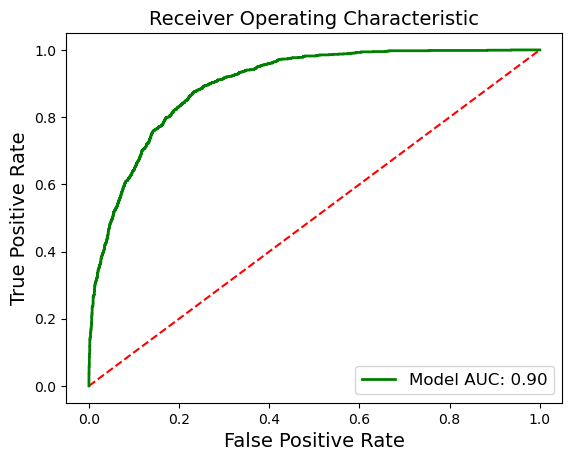

In [41]:
auc_curve(y_test, y_pred)

### Cummulative Accuracy Profile (CAP) Curve - Logistic Regression

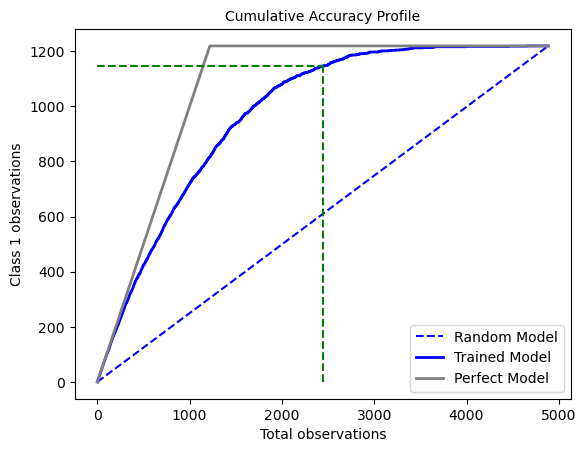

Percentage: 94.01%

    Interpret this percentage as follows:
    
    1. Less than 60%: Useless Model
    2. 60% - 70%: Poor Model
    3. 70% - 80%: Good Model
    4. 80% - 90%: Very Good Model
    5. More than 90%: Too Good to be True.

    In the fifth case, one must always check for overfitting.
    


In [42]:
cap_curve(y_test, y_pred)

### Confusion Matrix - Logistic Regression

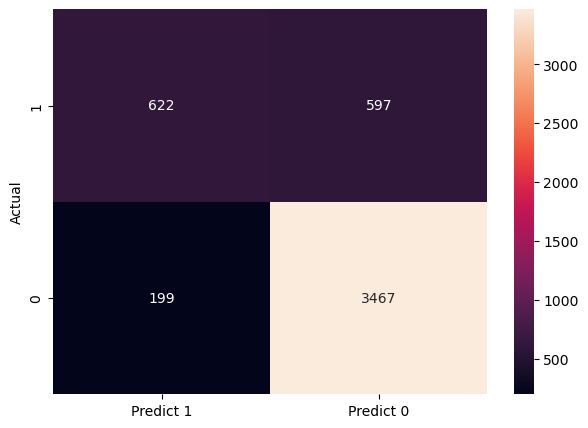

In [43]:
cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1, 0), labels = [1, 0])
cm_df = pd.DataFrame(cm, index = [1, 0], columns = ['Predict 1', 'Predict 0'])

plt.figure(figsize = (7, 5))
sns.heatmap(cm_df, annot = True, fmt = 'g')
plt.ylabel('Actual')
plt.show()

### Most Important Features - Odds Ratio

In [44]:
odds_ratio = np.exp(log_reg.coef_)

In [45]:
odds_ratio_df = pd.DataFrame(odds_ratio, columns = list(df_num_final)).T

In [46]:
odds_ratio_df.columns = ['odds']
data = odds_ratio_df.sort_values(by = 'odds', ascending = False)

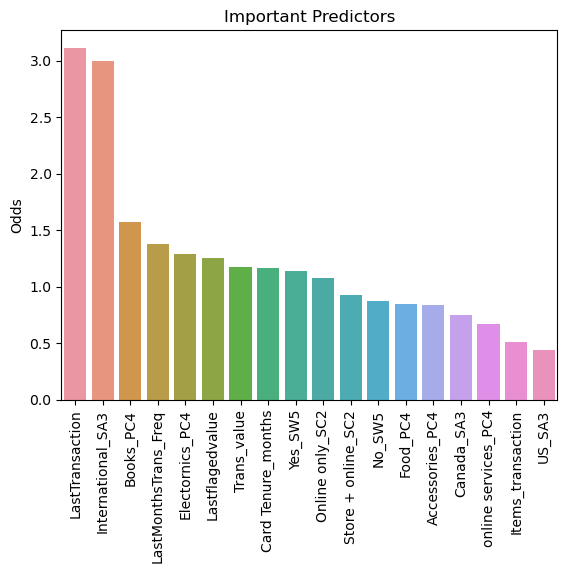

In [47]:
sns.barplot(data = data.T)
plt.title('Important Predictors')
plt.ylabel('Odds')
plt.xticks(rotation = 90)
plt.show()

### `AdaBoostClassifier` Model

In [48]:
ada_real = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 100, algorithm = "SAMME.R")
ada_real.fit(X_train, y_train)

scores = cross_val_score(ada_real, X, y)
print(f'ada_real validation score: {round(scores.mean(), 4)}') 

ada_real validation score: 0.8607


### The Predictions (AdaBoostClassifier Model)

In [49]:
y_pred_prob = ada_real.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)               
roc_auc = auc(fpr, tpr)  
print(f'ada real: roc prob -- auc {round(roc_auc, 3)}')

ada real: roc prob -- auc 0.911


In [50]:
acc_ada = metrics.accuracy_score(y_test, np.where(y_pred_prob > 0.5, 1, 0))
print(f'Accuracy (logistic Ada) = {acc_ada * 100: .2f}%')

Accuracy (logistic Ada) =  86.00%


### Receiver Operating Characteristic (ROC) Curve - AdaBoostClassifier Model

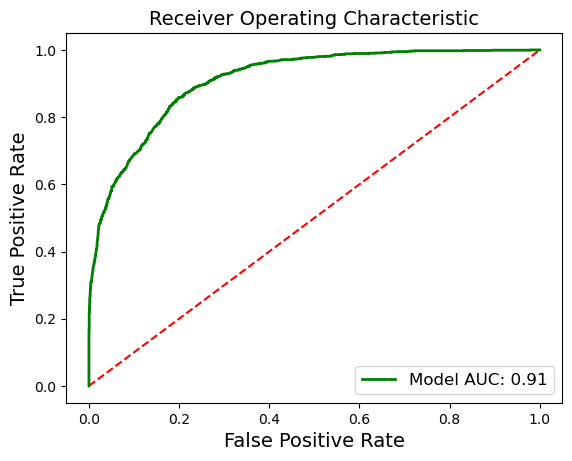

In [51]:
auc_curve(y_test, y_pred_prob)

### Cummulative Accuracy Profile (CAP) Curve - AdaBoostClassifier Model

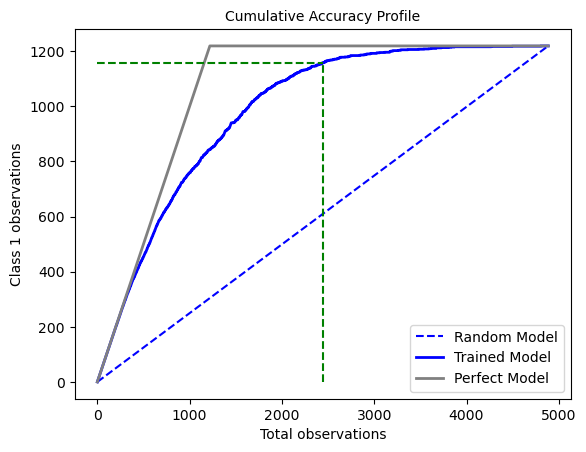

Percentage: 95.00%

    Interpret this percentage as follows:
    
    1. Less than 60%: Useless Model
    2. 60% - 70%: Poor Model
    3. 70% - 80%: Good Model
    4. 80% - 90%: Very Good Model
    5. More than 90%: Too Good to be True.

    In the fifth case, one must always check for overfitting.
    


In [52]:
cap_curve(y_test, y_pred_prob)

### Confusion Matrix - AdaBoostClassifier Model

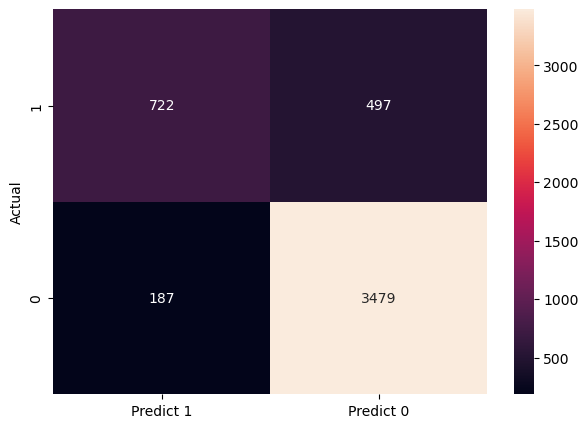

In [53]:
cm = confusion_matrix(y_test, np.where(y_pred_prob > 0.5, 1, 0), labels = [1, 0])
cm_df = pd.DataFrame(cm, index = [1, 0], columns = ['Predict 1', 'Predict 0'])

plt.figure(figsize = (7, 5))
sns.heatmap(cm_df, annot = True, fmt = 'g')
plt.ylabel('Actual')
plt.show()

#### Feature Importance - AdaBoostClassifier Model

In [54]:
def feature_importance(model, X_train):
    importance = pd.DataFrame({'Importance': model.feature_importances_*100}, index = X_train.columns)
    importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r', )
    plt.show()

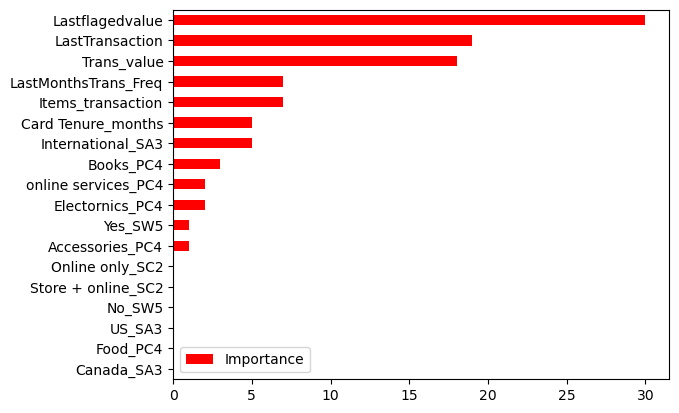

In [55]:
feature_importance(ada_real, X_train)

`AdaBoostClassifier` and `Logistic Regression` do not agree on which features are the most important in predicting the target. Further hyper-parameter tuning might be helpful...They both see **last transaction** as important. 